# 1 Setting up Spark NLP

In [1]:
# Mount google drive
#from google.colab import drive
#drive.mount('/content/drive')

In [2]:
# Install Java
#!apt-get install openjdk-8-jdk-headless -qq > /dev/null

# Download Spark
#if os.path.isfile("./spark-3.5.1-bin-hadoop3.tgz") == False:
#    !wget -q https://downloads.apache.org/spark/spark-3.5.1/spark-3.5.1-bin-hadoop3.tgz

# Unzip the file
#!tar xf spark-3.5.1-bin-hadoop3.tgz

# Setup environment for Spark
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = '/home/ubuntu/spark-3.5.1-bin-hadoop3'

# Import findspark and load it
#!pip install -q findspark
import findspark
findspark.init()

# Install spark-nlp
#!pip install spark-nlp
import sparknlp
from sparknlp.base import *
from sparknlp.annotator import *
from sparknlp.common import *
from pyspark.sql.functions import *
from pyspark.sql.functions import lit
from pyspark.sql.window import Window
from pyspark.sql.types import *
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml import Pipeline
from pyspark.ml.feature import StandardScaler, VectorAssembler, Imputer, OneHotEncoder, StringIndexer
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator, CrossValidatorModel, TrainValidationSplit, TrainValidationSplitModel
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.linalg import Vectors, VectorUDT
import pyspark.pandas as ps

# Create Spark session
#from pyspark.sql import SparkSession
#spark = SparkSession.builder\
#        .master("local")\
#        .appName("Spark NLP")\
#        .config('spark.executor.memory', "24g")\
#        .getOrCreate()

# Start Spark Session with Spark NLP
spark = sparknlp.start(gpu=True)
#spark = sparknlp.start(gpu=False)

/home/ubuntu/spark-3.5.1-bin-hadoop3/python/pyspark/pandas/__init__.py:50: UserWarning: 'PYARROW_IGNORE_TIMEZONE' environment variable was not set. It is required to set this environment variable to '1' in both driver and executor sides if you use pyarrow>=2.0.0. pandas-on-Spark will set it for you but it does not work if there is a Spark context already launched.
  warnings.warn(


:: loading settings :: url = jar:file:/home/ubuntu/spark-3.5.1-bin-hadoop3/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml

Ivy Default Cache set to: /home/ubuntu/.ivy2/cache

In [3]:
spark

# 2 Import libraries

In [4]:
# import spacy for NLP and re for regular expressions
import spacy
spacy.cli.download("en_core_web_sm")
import en_core_web_sm
from spacy.lang.en.stop_words import STOP_WORDS
import re

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [35]:
import time
import json
import pickle
import urllib.request
# import altair as alt
import pandas as pd
from sklearn.metrics import classification_report, fbeta_score
import collections
from collections import Counter
from sklearn.datasets import make_classification
from matplotlib import pyplot
from numpy import where
import imblearn

In [6]:
# visualization
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Image, display, HTML
import pydot
from pydotplus import graph_from_dot_data
from sklearn.tree import export_graphviz
from wordcloud import WordCloud

In [7]:
import xml.etree.ElementTree as ET
from xml.etree.ElementTree import ElementTree
import datetime

# 3 Load data

### 3.1 Obtain stratified training and test splits

In [8]:
#train_merged_data_conversations_path = f'drive/MyDrive/210 Capstone/data/train_merged_data_conversations'
#test_merged_data_conversations_path = f'drive/MyDrive/210 Capstone/data/test_merged_data_conversations'

#train_merged_data_conversations_df = spark.read.parquet(train_merged_data_conversations_path)
#test_merged_data_conversations_df = spark.read.parquet(test_merged_data_conversations_path)

In [9]:
train_merged_data_conversations_path = 's3a://capstone210/data/train_merged_data_conversations/'
test_merged_data_conversations_path = 's3a://capstone210/data/test_merged_data_conversations/'

train_merged_data_conversations_df = spark.read.parquet(train_merged_data_conversations_path)
test_merged_data_conversations_df = spark.read.parquet(test_merged_data_conversations_path)

In [10]:
#train_df_final = df.filter(col('source') != 'PAN12-test')
train_df_final = train_merged_data_conversations_df
test_df_final = test_merged_data_conversations_df

In [11]:
train_df_final.take(1)

[Row(conversation_id='0000604306a283600b730276a2039471', source='PAN12-train', label=0, conversation_start_time='13:04', n_people_in_conversation=4, type_conversation='Group', merged_text="e3fb62ebfa4f36acf5cbff6a6ed0f2e0: can I have your ear? e3fb62ebfa4f36acf5cbff6a6ed0f2e0: i am wondering if Opera implements, or plans to implement safari's &quot;device-pixel-ratio&quot; css media query. would you know? yes e.g. 1 CSS pixel to 3 device pixels would be 3.0 it's one-dimentional well it's explained here http://webkit.org/blog/55/high-dpi-web-sites/ though hyatt hasn't written up a formal defn i think no the ratio is applied in both directions think of it as the sqrt of the difference in number of pixels or better yet, think of it as the zoom factor 200% zoom would produce a factor of 2.0  (i.e. 2.0 squared more pixels per image) okay :) so I'm guessing opera doesn't support it yet. who would be the person to speak to about getting it implemented? where to? should I request an account or

In [12]:
train_df_final.describe()

DataFrame[summary: string, conversation_id: string, source: string, label: string, conversation_start_time: string, n_people_in_conversation: string, type_conversation: string, merged_text: string, merged_text_id: string, n_texts: string]

In [13]:
train_df_final.count()

87997

In [14]:
train_df_final.groupBy('label')\
              .agg(count('*').alias('count'))\
              .show(truncate = False)

+-----+-----+
|label|count|
+-----+-----+
|1    |2584 |
|0    |85413|
+-----+-----+



In [15]:
train_df_final.filter(col('label').isin([1])).show(truncate = True)

+--------------------+-----------+-----+-----------------------+------------------------+-----------------+--------------------+--------------------+-------+
|     conversation_id|     source|label|conversation_start_time|n_people_in_conversation|type_conversation|         merged_text|      merged_text_id|n_texts|
+--------------------+-----------+-----+-----------------------+------------------------+-----------------+--------------------+--------------------+-------+
|0014c1b4278df4bf8...|PAN12-train|    1|                  22:14|                       2|             Pair|hi how r ya? was ...|970f6cbfa8b792424...|    131|
|002ec0725fbeb1f5a...|PAN12-train|    1|                  08:08|                       1|        Monologue|                  hi|c62283536cf6261e5...|      1|
|0042866de4da52869...|PAN12-train|    1|                  20:49|                       1|        Monologue|        guess u left|fac3a2081264f1dbb...|      1|
|0063692c957229db0...|PAN12-train|    1|            

In [16]:
test_df_final.count()

155128

In [17]:
test_df_final.groupBy('label')\
             .agg(count('*').alias('count'))\
             .show(truncate = False)

+-----+------+
|label|count |
+-----+------+
|1    |2895  |
|0    |152233|
+-----+------+



# 4 Prepare Data before  BERT Tokenization


## 4.1 Type Casting and Clean up Labels

In [18]:
train_df_final.dtypes

[('conversation_id', 'string'),
 ('source', 'string'),
 ('label', 'int'),
 ('conversation_start_time', 'string'),
 ('n_people_in_conversation', 'int'),
 ('type_conversation', 'string'),
 ('merged_text', 'string'),
 ('merged_text_id', 'string'),
 ('n_texts', 'int')]

In [19]:
#train_df_final = train_df_final.withColumn("label", col("label").cast("integer"))

In [20]:
train_df_final.dtypes

[('conversation_id', 'string'),
 ('source', 'string'),
 ('label', 'int'),
 ('conversation_start_time', 'string'),
 ('n_people_in_conversation', 'int'),
 ('type_conversation', 'string'),
 ('merged_text', 'string'),
 ('merged_text_id', 'string'),
 ('n_texts', 'int')]

In [21]:
train_df_final = train_df_final.dropna()

In [22]:
train_df_final.groupBy('label').count().show()

+-----+-----+
|label|count|
+-----+-----+
|    1| 2584|
|    0|85413|
+-----+-----+



In [23]:
#train_df_final = train_df_final.filter((col('label') == 1) | (col('label') == 0))

In [24]:
train_df_final.summary().show()

+-------+--------------------+----------+--------------------+-----------------------+------------------------+-----------------+--------------------+--------------------+------------------+
|summary|     conversation_id|    source|               label|conversation_start_time|n_people_in_conversation|type_conversation|         merged_text|      merged_text_id|           n_texts|
+-------+--------------------+----------+--------------------+-----------------------+------------------------+-----------------+--------------------+--------------------+------------------+
|  count|               87997|     87997|               87997|                  87997|                   87997|            87997|               87997|               87997|             87997|
|   mean|             10534.5|      NULL|0.029364637430821506|                   NULL|       2.263758991783811|             NULL|2.502527525250252...|                NULL|14.464049910792413|
| stddev|    6082.52942176745|      NULL| 0.1

In [25]:
train_df_final.groupBy('label').count().show()

+-----+-----+
|label|count|
+-----+-----+
|    1| 2584|
|    0|85413|
+-----+-----+



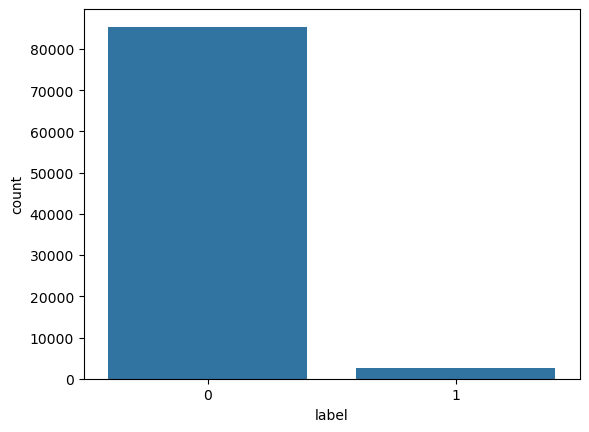

In [26]:
train_df_pandas = train_df_final.select('label').toPandas()
ax = sns.countplot(x="label", data=train_df_pandas)

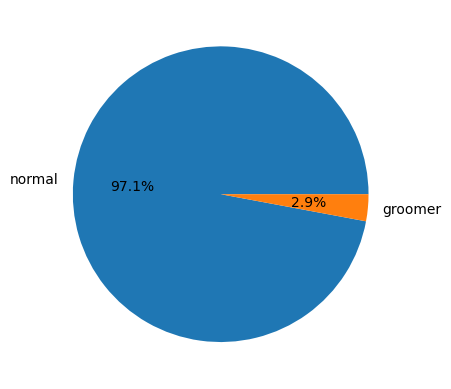

In [27]:
plt.pie(train_df_pandas["label"].value_counts(), labels=['normal','groomer'], autopct='%1.1f%%')
plt.show()

In [37]:
# function to undersample dataset automatically
# def undersample(df, outcome_col, seed=1234):
#   # Split dataset based on outcome
#   split0_df = df.filter(col(outcome_col) == 0)
#   split1_df = df.filter(col(outcome_col) == 1)
#   # determine which split is major vs minor
#   if (split0_df.count() > split1_df.count()):
#     major_df = split0_df
#     minor_df = split1_df
#   else:
#     minor_df = split0_df
#     major_df = split1_df
#   ratio = major_df.count()/minor_df.count()
#   print("Ratio of major vs minor before sampling: {}".format(ratio))
#   # Start under-sampling with Spark
#   sampled_majority_df = major_df.sample(False, 1/ratio, seed)
#   combined_df = sampled_majority_df.unionAll(minor_df)
#   print(f"Final sample size: {combined_df.count()}")
#   return combined_df

### 4.2 Use Spacy English to test tokenization first and remove those samples failed to convert

In [38]:
# Load the SpaCy en_core_web_sm model
nlp = spacy.load('en_core_web_sm', disable=["tagger", "parser", "ner"])

@staticmethod
def get_spacy():

    if "nlp" not in globals():
        globals()["nlp"] = nlp

    return globals()["nlp"]

doc1 = nlp("i love my pet dog")
doc2 = nlp("Maggie is my lovable pet dog!")
print(doc1.vector.size)
print(doc2.vector.size)
print("output:" , doc1.similarity(doc2))

96
96
output: 0.6314009741542267


/opt/conda/envs/pytorch/lib/python3.10/site-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)
/tmp/ipykernel_19354/749307361.py:16: UserWarning: [W007] The model you're using has no word vectors loaded, so the result of the Doc.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  print("output:" , doc1.similarity(doc2))


In [39]:
vec1 = nlp("i love my pet dog").vector
vec1

array([-0.82228184, -0.52981013, -0.04199264,  0.21913071, -0.03065448,
       -0.14778526,  0.6752845 ,  0.45747596, -0.14300331, -0.4820497 ,
       -0.2199707 , -0.31105405,  0.2607569 , -0.00689734, -0.7084032 ,
        0.24738555, -0.16439562,  0.2179037 , -0.37804666,  0.02349054,
       -0.15068911,  0.864818  , -0.637645  , -0.65831524,  0.22553782,
       -0.20611453, -0.23222873,  0.22810598, -0.2578836 , -0.1370413 ,
        0.5942478 ,  0.10742517,  0.18177323, -0.38608572,  0.0901499 ,
       -0.31681603, -0.04888222,  0.0951063 , -0.7534274 ,  0.35248774,
        0.08509431,  0.61296135,  0.23663417,  0.60823727, -0.5434038 ,
       -0.51587856, -0.15613341,  1.0582231 ,  0.28102857, -0.16917507,
       -0.8407737 ,  0.72302425,  0.32085943, -0.61701334,  0.05886409,
       -0.35398296,  0.5053838 ,  0.5155953 , -0.41034406, -0.1209401 ,
        0.40065938,  0.00445629,  0.5080544 ,  0.11423705,  0.06736588,
       -0.06459552,  0.24383393,  0.3004192 , -0.18886861, -0.43

In [40]:
type(vec1)

numpy.ndarray

#### Build PySpark UDF to convert words into vector

In [42]:
nlpUDF = udf(lambda x: nlp(x).vector.tolist(), ArrayType(FloatType()))

train_df_final = train_df_final.withColumn('array', nlpUDF(col('merged_text')))

In [43]:
arrayUDF = udf(lambda array: Vectors.dense(array), VectorUDT())

train_df_final = train_df_final.withColumn('vector', arrayUDF(col('array')))

In [44]:
train_df_final = train_df_final.withColumn('array_size', size(col('array')))

In [45]:
train_df_final.take(1)

[Row(conversation_id='0000604306a283600b730276a2039471', source='PAN12-train', label=0, conversation_start_time='13:04', n_people_in_conversation=4, type_conversation='Group', merged_text="e3fb62ebfa4f36acf5cbff6a6ed0f2e0: can I have your ear? e3fb62ebfa4f36acf5cbff6a6ed0f2e0: i am wondering if Opera implements, or plans to implement safari's &quot;device-pixel-ratio&quot; css media query. would you know? yes e.g. 1 CSS pixel to 3 device pixels would be 3.0 it's one-dimentional well it's explained here http://webkit.org/blog/55/high-dpi-web-sites/ though hyatt hasn't written up a formal defn i think no the ratio is applied in both directions think of it as the sqrt of the difference in number of pixels or better yet, think of it as the zoom factor 200% zoom would produce a factor of 2.0  (i.e. 2.0 squared more pixels per image) okay :) so I'm guessing opera doesn't support it yet. who would be the person to speak to about getting it implemented? where to? should I request an account or

In [46]:
train_df_final.filter(col("array_size") != 96).show()

+--------------------+-----------+-----+-----------------------+------------------------+-----------------+-----------+--------------+-------+-----+------+----------+
|     conversation_id|     source|label|conversation_start_time|n_people_in_conversation|type_conversation|merged_text|merged_text_id|n_texts|array|vector|array_size|
+--------------------+-----------+-----+-----------------------+------------------------+-----------------+-----------+--------------+-------+-----+------+----------+
|296b5fe667a3acb29...|PAN12-train|    1|                  16:26|                       1|        Monologue|           |              |      0|   []|    []|         0|
|413d86429dac924d6...|PAN12-train|    0|                  03:26|                       1|        Monologue|           |              |      0|   []|    []|         0|
|4e77cb2aab360fa8d...|PAN12-train|    0|                  23:20|                       1|        Monologue|           |              |      0|   []|    []|         0

#### Remove samples which failed to convert into vctors

In [47]:
train_df_final = train_df_final.filter(col("array_size") == 96)

In [48]:
train_df_final.groupBy('label').count().show()

+-----+-----+
|label|count|
+-----+-----+
|    1| 2583|
|    0|85401|
+-----+-----+



# 5 Model Building: Spark-NLP BERT Model

## 5.1 Use Spark-NLP BERT Pretrained English language model to turn words into embeddings and then run binary classifier for transferred-learning/fine-tuning


### Split dataset into training and validation

In [50]:
# split dataframes between 0s and 1s
zeros = train_df_final.filter(train_df_final["label"]==0)
ones = train_df_final.filter(train_df_final["label"]==1)
# split datasets into training and testing
train0, val0 = zeros.randomSplit([0.8,0.2], seed=1234)
train1, val1 = ones.randomSplit([0.8,0.2], seed=1234)
# stack datasets back together
trainingData = train0.union(train1)
validationData = val0.union(val1)

In [51]:
print("Training Dataset Count: " + str(trainingData.count()))
print("Validation Dataset Count: " + str(validationData.count()))

Training Dataset Count: 70472
Validation Dataset Count: 17512


In [52]:
trainingData.groupBy('label').count().show()

+-----+-----+
|label|count|
+-----+-----+
|    0|68375|
|    1| 2097|
+-----+-----+



In [53]:
validationData.groupBy('label').count().show()

+-----+-----+
|label|count|
+-----+-----+
|    0|17026|
|    1|  486|
+-----+-----+



### Oversampling training dataset

In [54]:
major_df = trainingData.filter(col("label") == 0)
minor_df = trainingData.filter(col("label") == 1)
ratio = int(major_df.count()/minor_df.count())
print("ratio: {}".format(ratio))

ratio: 32


In [55]:
a = range(ratio)
# duplicate the minority rows
oversampled_df = minor_df.withColumn("dummy", explode(array([lit(x) for x in a]))).drop('dummy')
# combine both oversampled minority rows and previous majority rows 
combined_oversampled_df = major_df.unionAll(oversampled_df)

In [56]:
combined_oversampled_df.groupBy('label').count().show()

+-----+-----+
|label|count|
+-----+-----+
|    0|68375|
|    1|67104|
+-----+-----+



In [57]:
trainingDataOversampled = combined_oversampled_df

### Build ML Pipeline with pretrained BERT English "Sentence" Model

In [63]:
# Step 1: Transforms raw texts to `document` annotation
document = DocumentAssembler()\
              .setInputCol("merged_text")\
              .setOutputCol("document")\
              .setCleanupMode("shrink")

# Step 2: Encodes text into high dimensional vectors
bert_sent = BertSentenceEmbeddings.pretrained('sent_small_bert_L8_512')\
              .setInputCols(["document"])\
              .setOutputCol("sentence_embeddings")

# Stage 3: Performs model training
classsifierdl = ClassifierDLApproach()\
                  .setInputCols(["sentence_embeddings"])\
                  .setOutputCol("class")\
                  .setLabelColumn("label")\
                  .setMaxEpochs(20)\
                  .setLr(0.001)\
                  .setBatchSize(32)\
                  .setEnableOutputLogs(True)

use_clf_pipeline = Pipeline(stages = [document,
                                      bert_sent,
                                      classsifierdl])


sent_small_bert_L8_512 download started this may take some time.
Approximate size to download 149.1 MB
[OK!]


## 5.2 Run Training

In [64]:
!pwd

/home/ubuntu/mids/capstone-210-spring2024/src/notebooks


In [65]:
# remove the existing logs
!rm -r /home/ubuntu/annotator_logs

rm: cannot remove '/home/ubuntu/annotator_logs': No such file or directory


In [66]:
# Fit the training dataset to train the model
t0 = time.time()
pipelineModel = use_clf_pipeline.fit(trainingDataOversampled)
print("Training time:", time.time()-t0)

ERROR:root:KeyboardInterrupt while sending command.
Traceback (most recent call last):
  File "/home/ubuntu/spark-3.5.1-bin-hadoop3/python/lib/py4j-0.10.9.7-src.zip/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "/home/ubuntu/spark-3.5.1-bin-hadoop3/python/lib/py4j-0.10.9.7-src.zip/py4j/clientserver.py", line 511, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
  File "/opt/conda/envs/pytorch/lib/python3.10/socket.py", line 705, in readinto
    return self._sock.recv_into(b)
KeyboardInterrupt


KeyboardInterrupt: 

In [61]:
log_files = os.listdir("/home/ubuntu/annotator_logs")

with open("/home/ubuntu/annotator_logs/"+log_files[0], "r") as log_file :
    print(log_file.read())

FileNotFoundError: [Errno 2] No such file or directory: '/home/ubuntu/annotator_logs'

## 5.3 Evaluate Validation Results

In [ ]:
%%time
# Apply Model Transform to Validation Data
preds = pipelineModel.transform(validationData)

In [ ]:
# We are going to use sklearn to evalute the results on validation dataset
preds_df = preds.select('label',"class.result").toPandas()

preds_df['result'] = preds_df['result'].apply(lambda x : int(x[0]))

print (classification_report(preds_df['label'], preds_df['result']))

In [ ]:
f_beta3_score = fbeta_score(preds_df['label'], preds_df['result'], average='binary', beta=3, pos_label=1)

In [ ]:
print("Validation F-beta3 score: ", f_beta3_score)

# 6 Save the Model and run the final Test Set

## 6.1 Save and Loading back the Trained Model

In [49]:
pipelineModel.stages

[DocumentAssembler_d56b7167b273,
 BERT_SENTENCE_EMBEDDINGS_3608c0d843af,
 ClassifierDLModel_bc6f1541425a]

In [50]:
pipelineModel.stages[2]

ClassifierDLModel_bc6f1541425a

In [51]:
# Save the BERT Classifier Model
pipelineModel.stages[2].write().overwrite().save('BertSentenceClfModelOverSampled')

In [56]:
# Save a Spark NLP pipeline
use_clf_pipeline.write().overwrite().save('BertClsPipelineOS')

In [10]:
# Load back saved BERT Classifier Model
TrainedClassifierDLModel = ClassifierDLModel.load('BertSentenceClfModelOverSampled')

In [11]:
# Generate prediction Pipeline with loaded Model
ld_pipeline = Pipeline(stages=[document, bert_sent, TrainedClassifierDLModel])
ld_pipeline_model = ld_pipeline.fit(spark.createDataFrame([['']]).toDF("text"))

## 6.2 Run against the Test Set

In [15]:
test_set = test_df_final

In [16]:
# Apply Model Transform to testData
preds_test = ld_pipeline_model.transform(test_set)

# We are going to use sklearn to evalute the results on test dataset
preds_test_df = preds_test.select('label',"class.result").toPandas()

preds_test_df['result'] = preds_test_df['result'].apply(lambda x : int(x[0]))

print (classification_report(preds_test_df['label'], preds_test_df['result']))

ERROR:root:KeyboardInterrupt while sending command.                 (0 + 2) / 2]
Traceback (most recent call last):
  File "/home/ubuntu/spark-3.5.1-bin-hadoop3/python/lib/py4j-0.10.9.7-src.zip/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "/home/ubuntu/spark-3.5.1-bin-hadoop3/python/lib/py4j-0.10.9.7-src.zip/py4j/clientserver.py", line 511, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
  File "/opt/conda/envs/pytorch/lib/python3.10/socket.py", line 705, in readinto
    return self._sock.recv_into(b)
KeyboardInterrupt


KeyboardInterrupt: 

In [72]:
f_beta3_test_score = fbeta_score(preds_test_df['label'], preds_test_df['result'], average='binary', beta=3, pos_label=1)

In [73]:
print("Test F-beta3 score: ", f_beta3_test_score)

Test F-beta3 score:  0.6562286938735755


# 7 Testing the Model on a set of Synthetic dataset

## 7.1 Load Synthetic Dataset

In [174]:
synthetic_data_conversations_path = f'/home/ubuntu/mids/capstone-210-spring2024/data/datasynthetic_conversations.csv/synthetic_data.csv'

In [175]:
synthetic_data_conversations_df = spark.read.csv(synthetic_data_conversations_path, header='true', inferSchema='true')

In [176]:
synthetic_data_conversations_df.count()

4

In [177]:
synthetic_data_conversations_df.show()

+---------------+---------+-----+-----------------------+------------------------+-----------------+--------------------+
|conversation_id|   source|label|conversation_start_time|n_people_in_conversation|type_conversation|         merged_text|
+---------------+---------+-----+-----------------------+------------------------+-----------------+--------------------+
|     US4MNWNVXW|synthetic|    1|    2024-03-04 04:00:00|                       2|             Pair|Hi. Hello. How ar...|
|     U84XQ4SEPW|synthetic|    1|    2024-03-04 16:00:00|                       2|             Pair|Hey baby, sorry I...|
|     FI1J20M2JO|synthetic|    1|    2024-03-04 14:00:00|                       2|             Pair|Hello! Hi who are...|
|     N62SK8ZA77|synthetic|    1|    2024-03-04 22:00:00|                       2|             Pair|Can I send you so...|
+---------------+---------+-----+-----------------------+------------------------+-----------------+--------------------+



In [178]:
test_set = synthetic_data_conversations_df

In [179]:
# Apply Model Transform to testData
preds_test = ld_pipeline_model.transform(test_set)

# We are going to use sklearn to evalute the results on test dataset
preds_test_df = preds_test.select('conversation_id','label',"class.result").toPandas()

preds_test_df['result'] = preds_test_df['result'].apply(lambda x : int(x[0]))

print (classification_report(preds_test_df['label'], preds_test_df['result']))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.50      0.67         4

    accuracy                           0.50         4
   macro avg       0.50      0.25      0.33         4
weighted avg       1.00      0.50      0.67         4



/opt/conda/envs/pytorch/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/envs/pytorch/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/envs/pytorch/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [180]:
preds_test_df

,conversation_id,label,result
0,US4MNWNVXW,1,0
1,U84XQ4SEPW,1,1
2,FI1J20M2JO,1,1
3,N62SK8ZA77,1,0


In [181]:
test_id_df = preds_test.select('conversation_id','merged_text').toPandas()
pd.set_option('max_colwidth', None)

test_id_df

,conversation_id,merged_text
0,US4MNWNVXW,"Hi. Hello. How are you? I’m good. U? Better now that I’m talking to you. Oh, is that so? Of course. How old are you? I’m not sure I’m supposed to be telling you that. Why not? You can trust me. I’m 16. I’m 16 too. What do you look like? I have brown hair and brown eyes. You? I have brown hair and blue eyes. I love brown eyes though. I bet you have a nice body. Why would you say that? You just sound sexy and your username is sexy. Well I’m not sexy at all. I think I’m ugly. No, I think you sound so beautiful. Well thank you. So what do you like to do for fun? Besides this game…. I like to skateboard. See that’s sexy. I love girls who skateboard. Do you go around here? Yes, sometimes to the park. We should go together sometime. I’m not really sure about that. My parents said I shouldn't meet strangers. Well I’m not a stranger still. We are friends right? I guess so. Maybe I can get your number and we can get to know each other better through text? Ok 845-375-3754."
1,U84XQ4SEPW,"Hey baby, sorry I’m late. Lol I’m not your baby. To me you are :) We just met a couple days ago. You have to earn it. Challenge accepted. How was your day? It was good I did a lot of thinking. Thinking about what? You of course and how beautiful I bet you are. Well thank you. Have you ever sent anyone nude photos? Nope I’ve always been too scared. Well do you trust me? Of course I do. You should send me some if you want to. I promise I wouldn’t show anyone. Okay only if you promise. I swear beautiful. I don’t know how to… what should I do? Go to the bathroom and get naked. Make sure your parents aren’t home. Take pictures of your pussy and boobs and send them to my email address. Make sure you delete the email after you send it. Okay I’ll do that tomorrow. Why not tonight? My parents are home. Okay baby. I can’t wait to see them."
2,FI1J20M2JO,"Hello! Hi who are you? I’m Jimmy. I’m new to town. How come I don’t recognize your name? I got your name from our friend Katie at school. You know Katie? Yes. And she told me how awesome you are. Okay then nice to meet you. Did you just move here? Yes I’m new to town. Thought you could introduce me to your friends this summer. Katie is my only friend right now… so I don’t have many to share with you. Oh really why is that? You wouldn’t understand. I don’t have many friends either…. I’ll share my story if you share yours? We might have more in common than you think. Okay that makes me feel better. I hooked up with Jaice’s boyfriend this summer and now they all hate me. Conner swore he was going to end things with her and didn’t so I got fucked.Now everyone hates me. I don’t hate you. I have a similar story as well. I had sex with a girl who decided she didn’t like me and told everyone I was a loser. Everyone decided they didn’t like me and bullied me so my parents moved me to school. People can be assholes. Wow, we are more alike than I thought. We could be friends with each other? Yes, friends. Since we are friends, would you ever want to hangout? You mean just us? Yes why not. I’d like to see you in person. Ok. Should we meet at the park? Why do you come to my house? My parents will be gone tomorrow. Ok let me ask my parents.Wait no don’t ask them! Why not? Because they’ll say no if my parents aren’t home. You should just say you are coming to the park and then come to my house. I can give you the address. Okay sounds good. 595 Cheshire Lane. Come over tomorrow at 2? Sounds good, see you then."
3,N62SK8ZA77,"Can I send you something? What do you mean? You said that you trust me and you had never seen boobs before. I’m wondering if I can trust you. I trust you. And you would keep this a secret if I showed you? You couldn’t tell anyone, not even your friends and especially not your parents. Okay. You promise? Promise. I just sent you my boobs to your email. Tell me if you like them. Wow. They’re hot. Are you a milf? Yes ;) I can’t tell you my age just yet. Why not? I have 

In [182]:
pd_df = synthetic_data_conversations_df.toPandas()

In [183]:
#define condition
mask = (pd_df['conversation_id'] == 'US4MNWNVXW')

#add string to values in column equal to 'A'
pd_df.loc[mask, 'merged_text'] = pd_df['merged_text'].astype(str) + " Make sure you don't tell your parents."

In [184]:
#define condition
mask = (pd_df['conversation_id'] == 'N62SK8ZA77')

#add string to values in column equal to 'A'
pd_df.loc[mask, 'merged_text'] = " Hey baby, sorry I’m late. Lol I’m not your baby. To me you are :) We just met a couple days ago. You have to earn it. Challenge accepted."

In [185]:
pd_df

,conversation_id,source,label,conversation_start_time,n_people_in_conversation,type_conversation,merged_text
0,US4MNWNVXW,synthetic,1,2024-03-04 04:00:00,2,Pair,"Hi. Hello. How are you? I’m good. U? Better now that I’m talking to you. Oh, is that so? Of course. How old are you? I’m not sure I’m supposed to be telling you that. Why not? You can trust me. I’m 16. I’m 16 too. What do you look like? I have brown hair and brown eyes. You? I have brown hair and blue eyes. I love brown eyes though. I bet you have a nice body. Why would you say that? You just sound sexy and your username is sexy. Well I’m not sexy at all. I think I’m ugly. No, I think you sound so beautiful. Well thank you. So what do you like to do for fun? Besides this game…. I like to skateboard. See that’s sexy. I love girls who skateboard. Do you go around here? Yes, sometimes to the park. We should go together sometime. I’m not really sure about that. My parents said I shouldn't meet strangers. Well I’m not a stranger still. We are friends right? I guess so. Maybe I can get your number and we can get to know each other better through text? Ok 845-375-3754. Make sure you don't tell your parents."
1,U84XQ4SEPW,synthetic,1,2024-03-04 16:00:00,2,Pair,"Hey baby, sorry I’m late. Lol I’m not your baby. To me you are :) We just met a couple days ago. You have to earn it. Challenge accepted. How was your day? It was good I did a lot of thinking. Thinking about what? You of course and how beautiful I bet you are. Well thank you. Have you ever sent anyone nude photos? Nope I’ve always been too scared. Well do you trust me? Of course I do. You should send me some if you want to. I promise I wouldn’t show anyone. Okay only if you promise. I swear beautiful. I don’t know how to… what should I do? Go to the bathroom and get naked. Make sure your parents aren’t home. Take pictures of your pussy and boobs and send them to my email address. Make sure you delete the email after you send it. Okay I’ll do that tomorrow. Why not tonight? My parents are home. Okay baby. I can’t wait to see them."
2,FI1J20M2JO,synthetic,1,2024-03-04 14:00:00,2,Pair,"Hello! Hi who are you? I’m Jimmy. I’m new to town. How come I don’t recognize your name? I got your name from our friend Katie at school. You know Katie? Yes. And she told me how awesome you are. Okay then nice to meet you. Did you just move here? Yes I’m new to town. Thought you could introduce me to your friends this summer. Katie is my only friend right now… so I don’t have many to share with you. Oh really why is that? You wouldn’t understand. I don’t have many friends either…. I’ll share my story if you share yours? We might have more in common than you think. Okay that makes me feel better. I hooked up with Jaice’s boyfriend this summer and now they all hate me. Conner swore he was going to end things with her and didn’t so I got fucked.Now everyone hates me. I don’t hate you. I have a similar story as well. I had sex with a girl who decided she didn’t like me and told everyone I was a loser. Everyone decided they didn’t like me and bullied me so my parents moved me to school. People can be assholes. Wow, we are more alike than I thought. We could be friends with each other? Yes, friends. Since we are friends, would you ever want to hangout? You mean just us? Yes why not. I’d like to see you in person. Ok. Should we meet at the park? Why do you come to my house? My parents will be gone tomorrow. Ok let me ask my parents.Wait no don’t ask them! Why not? Because they’ll say no if my parents aren’t home. You should just say you are coming to the park and then come to my house. I can give you the address. Okay sounds good. 595 Cheshire Lane. Come over tomorrow at 2? Sounds good, see you then."
3,N62SK8ZA77,synthetic,1,2024-03-04 22:00:00,2,Pair,"Hey baby, sorry I’m late. Lol I’m not your baby. To me you are :) We just met a couple days ago. You have to earn it. Challenge accepted."


In [186]:
modified_data_conversations_df = spark.createDataFrame(pd_df)

In [187]:
modified_data_conversations_df.show()

+---------------+---------+-----+-----------------------+------------------------+-----------------+--------------------+
|conversation_id|   source|label|conversation_start_time|n_people_in_conversation|type_conversation|         merged_text|
+---------------+---------+-----+-----------------------+------------------------+-----------------+--------------------+
|     US4MNWNVXW|synthetic|    1|    2024-03-04 04:00:00|                       2|             Pair|Hi. Hello. How ar...|
|     U84XQ4SEPW|synthetic|    1|    2024-03-04 16:00:00|                       2|             Pair|Hey baby, sorry I...|
|     FI1J20M2JO|synthetic|    1|    2024-03-04 14:00:00|                       2|             Pair|Hello! Hi who are...|
|     N62SK8ZA77|synthetic|    1|    2024-03-04 22:00:00|                       2|             Pair| Hey baby, sorry ...|
+---------------+---------+-----+-----------------------+------------------------+-----------------+--------------------+



In [188]:
test_set = modified_data_conversations_df

In [189]:
# Apply Model Transform to testData
preds_test = ld_pipeline_model.transform(test_set)

# We are going to use sklearn to evalute the results on test dataset
preds_test_df = preds_test.select('conversation_id','label',"class.result").toPandas()

preds_test_df['result'] = preds_test_df['result'].apply(lambda x : int(x[0]))

print (classification_report(preds_test_df['label'], preds_test_df['result']))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.75      0.86         4

    accuracy                           0.75         4
   macro avg       0.50      0.38      0.43         4
weighted avg       1.00      0.75      0.86         4



/opt/conda/envs/pytorch/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/envs/pytorch/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/envs/pytorch/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [190]:
preds_test_df

,conversation_id,label,result
0,US4MNWNVXW,1,0
1,U84XQ4SEPW,1,1
2,FI1J20M2JO,1,1
3,N62SK8ZA77,1,1


# The following are backup code


In [191]:
# grid = ParamGridBuilder()\
#       .addGrid(classsifierdl.batchSize, [16])\
#       .addGrid(classsifierdl.lr, [0.001])\
#       .addGrid(classsifierdl.maxEpochs, [10])\
#       .build()
# evaluator = MulticlassClassificationEvaluator(metricName='fMeasureByLabel', beta=3, metricLabel=1)
# tvs = TrainValidationSplit(estimator=use_clf_pipeline, estimatorParamMaps=grid, evaluator=evaluator, trainRatio=0.80, parallelism=1, seed=1234)
# start_time = time.time()
# tvsModel = tvs.fit(dataset)
# stop_time = time.time()
# print(f"Training time: {stop_time - start_time}s")
# tvsModel.getTrainRatio()